In [1]:
# Area under curve for finding step frequecny
# Find step frequencies for continuous segments
# Speed find the running speed in continuous intervals

import Data
from IPython.display import clear_output
from tensorflow.keras import layers
from keras import backend as k
import IPython
import numpy as np
import Data
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import model
from model import build_model_CNN

from plotter import hist_plotter

import os

In [3]:
# Get Data Here
Features_A, Labels, pIDs = Data.dataset_main(150,50,'Yes')
Features_G, Labels, pIDs = Data.dataset_main(150,50,'No')
clear_output()
print('Dataset Loaded')

Dataset Loaded


In [4]:
pIDsUnique = np.unique(pIDs)
pIDsUnique
pIDsInts = np.arange(len(pIDsUnique))
pIDsDict = dict()
for i, ID in enumerate(pIDsUnique):
    pIDsDict[ID] = pIDsInts[i]

pIDsVals = np.array([pIDsDict[ID] for ID in pIDs]).reshape(-1,1)

In [91]:
from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder(sparse=False)
pIDsEnc = oneHot.fit_transform(pIDsVals)

In [6]:


physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print('Could not initialize the tensorflow gpu')
    pass



In [7]:

def R_Square(y_true, y_pred):

    Num = k.sum(k.square(y_true - y_pred))
    Denom = k.sum(k.square(y_true - k.mean(y_true)))
    R = 1 - Num / (Denom + k.epsilon())
    return R


def build_model_CNN():
    inputA = layers.Input(shape=(3, 150, 1))
    modelA = inputA
    min_conv1 = 27
    max_conv1 = 36
    min_conv2 = 36
    max_conv2 = 45
    modelA = layers.Conv2D(27,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(inputA)

    modelA = layers.Conv2D(45,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(modelA)

    #modelA = layers.Flatten()(modelA)
    modelA = layers.GlobalMaxPool2D()(modelA)
    inputG = layers.Input(shape=(3, 150, 1))

    modelG = inputG

    modelG = layers.Conv2D(27,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(inputG)

    modelG = layers.Conv2D(45,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(modelG)

    # model = layers.Dropout(0.4)(model)
    #modelG = layers.Flatten()(modelG)
    modelG = layers.GlobalMaxPool2D()(modelG)
    model = layers.Concatenate()([modelA, modelG])
    #   layers.concatenate(modelA,modelG)

    #model = layers.Dropout(0.4)(model)

    model = layers.Dense(180, activation='relu')(model)

    model = layers.Dropout(0.3)(model)

    model = layers.Dense(30, activation='relu')(model)

    model = layers.Dropout(0.3)(model)

    output = layers.Dense(1)(model)

    model = tf.keras.Model(inputs=[inputA, inputG], outputs=output)

    optimizer = tf.keras.optimizers.RMSprop(1e-3)
    # optimizer = tf.keras.optimizers.Adam(1e-3)

    loss1 = tf.keras.losses.MeanAbsoluteError(name="mean_absolute_error")
    
    loss2 = tf.keras.losses.MeanAbsoluteError(name="mean_absolute_error")

    model.compile(
        loss=[loss1,loss2],  #'mean_absolute_error',
        optimizer=[optimizer1,optimizer2],
        metrics=[['mae', 'mape', R_Square],['accuracy']])

    tf.keras.utils.plot_model(model,
                            #  to_file='/home/redev/Pictures/Model.png',
                              show_shapes=True)
    return model



In [94]:

def R_Square(y_true, y_pred):

    Num = k.sum(k.square(y_true - y_pred))
    Denom = k.sum(k.square(y_true - k.mean(y_true)))
    R = 1 - Num / (Denom + k.epsilon())
    return R


def build_model_CNN():
    inputA = layers.Input(shape=(3, 150, 1))
    modelA = inputA
    min_conv1 = 27
    max_conv1 = 36
    min_conv2 = 36
    max_conv2 = 45
    modelA = layers.Conv2D(27,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(inputA)

    modelA = layers.Conv2D(45,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(modelA)

    #modelA = layers.Flatten()(modelA)
    modelA = layers.GlobalMaxPool2D()(modelA)
    inputG = layers.Input(shape=(3, 150, 1))

    modelG = inputG

    modelG = layers.Conv2D(27,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(inputG)

    modelG = layers.Conv2D(45,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu')(modelG)

    # model = layers.Dropout(0.4)(model)
    #modelG = layers.Flatten()(modelG)
    modelG = layers.GlobalMaxPool2D()(modelG)
    model = layers.Concatenate()([modelA, modelG])
    #   layers.concatenate(modelA,modelG)

    #model = layers.Dropout(0.4)(model)

    model = layers.Dense(180, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(30, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    output = layers.Dense(15)(model)

    model = tf.keras.Model(inputs=[inputA, inputG], outputs=output)

    #optimizer = tf.keras.optimizers.RMSprop(1e-3)
    optimizer = tf.keras.optimizers.Adam(1e-3)

    #loss1 = tf.keras.losses.MeanAbsoluteError(name="mean_absolute_error")
    
    #loss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss2=tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(
        loss=loss2,  #'mean_absolute_error',
        optimizer=optimizer,
        metrics=['accuracy'])

    tf.keras.utils.plot_model(model,
                            #  to_file='/home/redev/Pictures/Model.png',
                              show_shapes=True)
    return model

In [95]:


class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)



earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=50)

reduceLRplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       min_lr=1e-6,
                                                       patience=30,
                                                       factor=0.9,
                                                       verbose=1)

if os.path.isdir('logdir'):
    pass
else:
    os.mkdir('logdir')

logdir = 'logdir'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)



In [96]:
model = build_model_CNN()
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 3, 150, 1)]  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 3, 150, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 3, 150, 27)   270         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 3, 150, 27)   270         input_20[0][0]                   
____________________________________________________________________________________________

In [97]:
import tensorflow.compat.v2 as tf


class EpochDots(tf.keras.callbacks.Callback):
  """A simple callback that prints a "." every epoch, with occasional reports.
  Args:
    report_every: How many epochs between full reports
    dot_every: How many epochs between dots.
  """

  def __init__(self, report_every=100, dot_every=1):
    self.report_every = report_every
    self.dot_every = dot_every

  def on_epoch_end(self, epoch, logs):
    if epoch % self.report_every == 0:
      print()
      print('Epoch: {:d}, '.format(epoch), end='')
      for name, value in sorted(logs.items()):
        print('{}:{:0.4f}'.format(name, value), end=',  ')
      print()

    if epoch % self.dot_every == 0:
      print('.', end='')

In [89]:
pIDsEnc[0]

<1x15 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [107]:
X_TrainA, X_TestA, y_TrainA, y_TestA = train_test_split(Features_A, pIDsVals, test_size=0.15, shuffle=True, random_state=90)
X_TrainG, X_TestG, y_TrainG, y_TestG = train_test_split(Features_G, pIDsVals, test_size=0.15, shuffle=True, random_state=90)


X_TrainA, X_ValA, y_TrainA, y_ValA = train_test_split(X_TrainA, y_TrainA, test_size=0.18, shuffle=True, random_state=90)
X_TrainG, X_ValG, y_TrainG, y_ValG = train_test_split(X_TrainG, y_TrainG, test_size=0.18, shuffle=True, random_state=90)

In [ ]:
##############This is for classification problem

hist = model.fit(
    [X_TrainA, X_TrainG],
    y_TrainA,
 #   validation_data=([Features_A, Features_G], Labels),
    validation_data = ([X_ValA, X_ValG], y_ValA),
    epochs=1200,
    verbose=0,
    callbacks=[
        EpochDots(report_every=30)
       # ,
       #    earlystopping#,
        #reduceLRplateau
        
      #  tensorboard_callback,
        #ClearTrainingOutput()
    ])

hist_plotter(hist.history)
print("Results of the model training")


Epoch: 0, accuracy:0.0793,  loss:2.9707,  val_accuracy:0.0837,  val_loss:2.7081,  
..............................
Epoch: 30, accuracy:0.0745,  loss:2.8776,  val_accuracy:0.0837,  val_loss:2.7081,  
..............................
Epoch: 60, accuracy:0.0719,  loss:2.9422,  val_accuracy:0.0837,  val_loss:2.7081,  
..............................
Epoch: 90, accuracy:0.0729,  loss:2.9039,  val_accuracy:0.0837,  val_loss:2.7081,  
..............................
Epoch: 120, accuracy:0.0761,  loss:2.8982,  val_accuracy:0.0837,  val_loss:2.7081,  
..............................
Epoch: 150, accuracy:0.0764,  loss:2.8527,  val_accuracy:0.0837,  val_loss:2.7081,  
..............................
Epoch: 180, accuracy:0.0767,  loss:2.8862,  val_accuracy:0.0837,  val_loss:2.7081,  
..............................
Epoch: 210, accuracy:0.0658,  loss:2.8313,  val_accuracy:0.0837,  val_loss:2.7081,  
..............................
Epoch: 240, accuracy:0.0590,  loss:2.8423,  val_accuracy:0.0631,  val_loss:2

In [104]:
np.argmax(model.predict([X_TestA,X_TestG]), axis = 1)
model.predict([X_TestA,X_TestG])[:2]

array([[-37916.883, -29674.44 , -25937.16 , -21046.234, -23800.418,
        -30665.285, -26406.182, -43073.29 , -18562.162, -38903.785,
        -39795.797, -21383.268, -23558.658, -39953.46 , -27734.79 ],
       [-19405.664, -15241.785, -13336.896, -10819.651, -12269.63 ,
        -15785.226, -13591.766, -22153.262,  -9542.875, -20004.652,
        -20397.58 , -11082.527, -12083.86 , -20511.262, -14127.963]],
      dtype=float32)

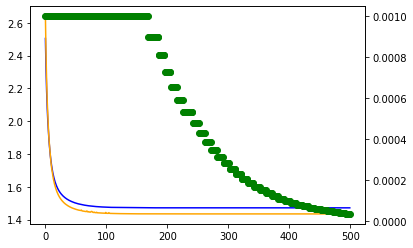

Results of the model training


In [41]:

hist = model.fit(
    [Features_A, Features_G],
    np.array(Labels).reshape(-1,1),
 #   validation_data=([Features_A, Features_G], Labels),
    validation_split = 0.3,
    epochs=500,
    verbose=3,
    callbacks=[
        #        earlystopping,
        reduceLRplateau,
        
      #  tensorboard_callback,
        ClearTrainingOutput()
    ])

hist_plotter(hist.history)
print("Results of the model training")

In [35]:

hist = model.fit(
    [Features_A, Features_G],
    np.array(Labels).reshape(-1,1),
 #   validation_data=([Features_A, Features_G], Labels),
    validation_split = 0.3,
    epochs=500,
    verbose=3,
    callbacks=[
        #        earlystopping,
        reduceLRplateau,
      #  tensorboard_callback,
        EpochDots(),
        ClearTrainingOutput()
    ])

hist_plotter(hist.history)
print("Results of the model training")

Epoch 1/500


ValueError: in user code:

    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:1527 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4561 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/redev/anaconda3/envs/pyHAI/lib/python3.6/site-packages/tensorflow/python/framework/tensor_shape.py:1117 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 15) are incompatible


In [8]:
print(model.evaluate([Features_A, Features_G], np.array(Labels)))

140/140 [==============================] - 0s 2ms/step - loss: 0.2197 - mae: 0.2197 - mape: 4.6151 - R_Square: -5361.2163
[0.219736710190773, 0.219736710190773, 4.615148067474365, -5361.21630859375]


In [9]:
values = np.hstack((np.array(Labels).reshape(-1,1), np.array(pIDs).reshape(-1,1)))
data_df = pd.DataFrame(values, columns = ['speed', 'person'])

In [10]:
data_df['error'] = 0 

In [ ]:

uniquePID = np.unique(data_df['pIDs'])

uniqueSpeed = np.unique(data_df['speed'])

In [ ]:
uniquePID

In [ ]:
uniqueSpeed

In [ ]:
for up i